# Mecury Perhelion Procession

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Background

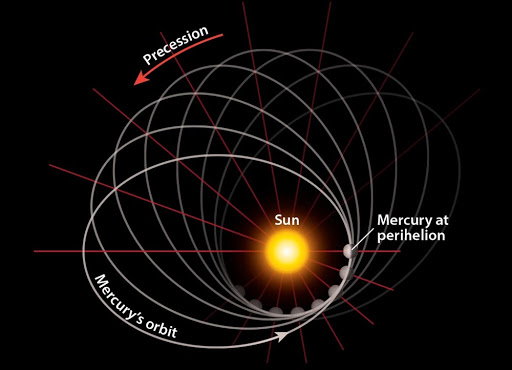


The total perihelion precession rate for Mercury is 5.32+0.43= 5.75 arc seconds per year, where the 5.32 comes from the Newtonian contribution and before General Relativity the 0.43 arc seconds per year was a long standing discrepancy that cannot be solved. It turns out, the ability of general relativity to explain the discrepancy between the observed perihelion precession rate of Mercury, and that calculated from Newtonian dynamics, was one of the first major successes of this theory.

The following text and codes are prepared by Mr.[Tim-Lok Chau](https://quantummc.xyz/members/tim-lok-chau/) and [ZYM](https://quantummc.xyz/members/ziyang-meng/) utilising the following useful references:

1. A primer to numerical simulations: the perihelion motion of Mercury, \\
C Körber, I Hammer, J-L Wynen, J Heuer, C Müller and C Hanhart  \\
[Phys. Educ. 53 055007 (2018)](https://iopscience.iop.org/article/10.1088/1361-6552/aac487)

2. Lecture notes on Newtonian Dynamics by Prof. Richard Fitzpatrick, The University of Texas at Austin \\
Chapter on Gravitational Potential Theory \\
[Perihelion Precession of Mercury](https://farside.ph.utexas.edu/teaching/336k/Newton/node116.html)

The Mecury perhelion procession can be described by the following equation,

$$\ddot{\vec{r}} = - \frac{c^2}{2} \frac{r_s}{r^2} ( 1 + \alpha \frac{r_s}{r} + \beta \frac{r_L^2}{r^2} ) \frac{\vec{r}}{r}$$

where,
- $c$ is the light speed
- $r_s$ is the Schwarzschild radius. It is defined as $\frac{2 G_N M_{sun}}{c^2}$, where $G_N$ is the Newtonian constant of gravition and $M_{sun}$ is the mass of sun
- $r_L$ is the constant that characterize the dynamics of Mercury.

It is worthwhile to mention that $\alpha$ & $\beta$ are constants that characterize the correction to the Mercury's orbit. With $\alpha = \beta = 0$, the differential equation above would become a standard Newtonian law of gravitation (i.e. $a = \frac{GM}{r^2} \frac{\vec{r}}{r}$) between 2 bodies.

### Discussion of the choice of $\Delta t$

Before we get into the updating process, it is worthwhile to discuss the choice of $\Delta t$. A large $\Delta t$ would lead to accumulation of error during update (as shown in last [colab notebook](https://colab.research.google.com/github/timlok123/PHYS4150-Computational-Physics-2024/blob/main/Solving%20ODE/Differential_Equations_1_Methods.ipynb)). In order to choose a suitable $\Delta t$, one can consider the Talyor expansion of position vector $\vec{r}$ at $t+\Delta t$ time steps (i.e. $\vec{r}(t+\Delta t)$),  

$$\vec{r}(t+ \Delta t) = \vec{r}(t) + \dot{\vec{r}}(t) \Delta t + \frac{1}{2} \ddot{\vec{r}}(t) (\Delta  t)^2 + ... = \vec{r}(t) + \vec{v}(t) \Delta  t+ \frac{1}{2} \vec{a}(t) (\Delta  t)^2 + ...$$

If we are using Euler method to update the position, then we'd better make sure  $|\vec{v}(t)| >> |\frac{1}{2} \vec{a}(t) (\Delta  t)|$  (This is also applicable to other methods), such that the higher order terms won't dominate.

## Different ODE solving methods

In [2]:
def derivative(X_t, c_a, alpha, beta, rS, rL2):

    # We know that it is a 2D problem so we hardcode the dimensionality
    position_vector = np.array(X_t[:2])
    velocity_vector = np.array(X_t[2:])

    bracket_term = 1 + alpha*rS/np.linalg.norm(position_vector) + beta*rL2/np.linalg.norm(position_vector)**2
    aMS = (c_a * bracket_term) / np.linalg.norm(position_vector)**2

    # Calculate the update in velocity
    dv = - (aMS * position_vector) / np.linalg.norm(position_vector)

    # Calculate the update in position
    dr = velocity_vector

    return  np.concatenate((dr, dv))

### Euler Method

In [3]:
def Euler(derivative, initial_condition, dt, nt, c_a, alpha, beta, rS, rL2):

    X = np.zeros([nt, len(initial_condition)])  # X = [ [x0,y0,vx0,vy0] , [x1,y1,vx1,vy1] , ... ]
    X[0] = initial_condition

    for i in range(nt-1):
        X[i+1] = X[i] + derivative(X[i], c_a, alpha, beta, rS, rL2) * dt

    return X

### Leap Frog Method

In [4]:
def Leap_Frog(derivative, initial_condition, dt, nt, c_a, alpha, beta, rS, rL2):

  # Extract initial position and velocity
  initial_position = initial_condition[:2]
  initial_velocity = initial_condition[2:]

  # Calculate starting velocity - v(-1/2)
  starting_acceleration = derivative(initial_condition, c_a, alpha, beta, rS, rL2)[2:]
  starting_velocity = initial_velocity  - 1/2 * dt * starting_acceleration

  # Calculate 1st element in velocity part - v(1/2)
  first_velocity = starting_velocity + dt * derivative(initial_condition, c_a, alpha, beta, rS, rL2)[2:]

  X = np.zeros([nt, len(initial_condition)])
  X[0] = np.concatenate((initial_position, first_velocity))

  for i in range(nt-1):
    X[i+1] = X[i] +  derivative(X[i], c_a, alpha, beta, rS, rL2) * dt

  return X

### 4th order Runge Kutta Method

In [5]:
def Runge_kutta_4th(derivative, initial_condition, dt, nt, c_a, alpha, beta, rS, rL2):

    X = np.zeros([nt, len(initial_condition)])
    X[0] = initial_condition

    for i in range(nt-1):
        k1 = derivative(X[i], c_a, alpha, beta, rS, rL2)
        k2 = derivative(X[i] + dt/2* k1, c_a, alpha, beta, rS, rL2)
        k3 = derivative(X[i] + dt/2* k2, c_a, alpha, beta, rS, rL2)
        k4 = derivative(X[i] + dt * k3, c_a, alpha, beta, rS, rL2)

        X[i+1] = X[i] + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

    return X

In order to make the procession of Mercury Perhelion more obvious, the eccentricity of the orbit are tuned to be higher (i.e. setting the initial radius of Mercury to be $6 R_0$ instead of $4 R_0$ and the $\alpha$ are set to a large value)

In [10]:
# Definition of parameters
rM0 = 6         # Mercury orbit, in units of R0
vM0 = 5.10e-1   # Initial speed of Mercury, in units of R0/T0
c_a = 9.90e-1   # Base acceleration of Mercury, in units of R0**3/T0**2
TM = 8.80e+1    # Orbit period of Mercury
rS = 2.95e-7    # Schwarzschild radius of Sun,in units of R0
rL2 = 8.19e-7   # Specific angular momentum, in units of R0**2

# Time step
dt =  (2 * vM0 / c_a) / 10

t = 0.0
alpha = 10**6
beta = 10**6
nt = 200000
initial_condition = [rM0, 0.0, 0.0, vM0]


# X = [ [x0,y0,vx0,vy0] , [x1,y1,vx1,vy1] , ... ]
X_Euler = Euler(derivative, initial_condition, dt, nt, c_a, alpha, beta, rS, rL2)
X_LF    = Leap_Frog(derivative, initial_condition, dt, nt, c_a, alpha, beta, rS, rL2)
X_RK    = Runge_kutta_4th(derivative, initial_condition, dt, nt, c_a, alpha, beta, rS, rL2)

### Result by different ODE solving methods

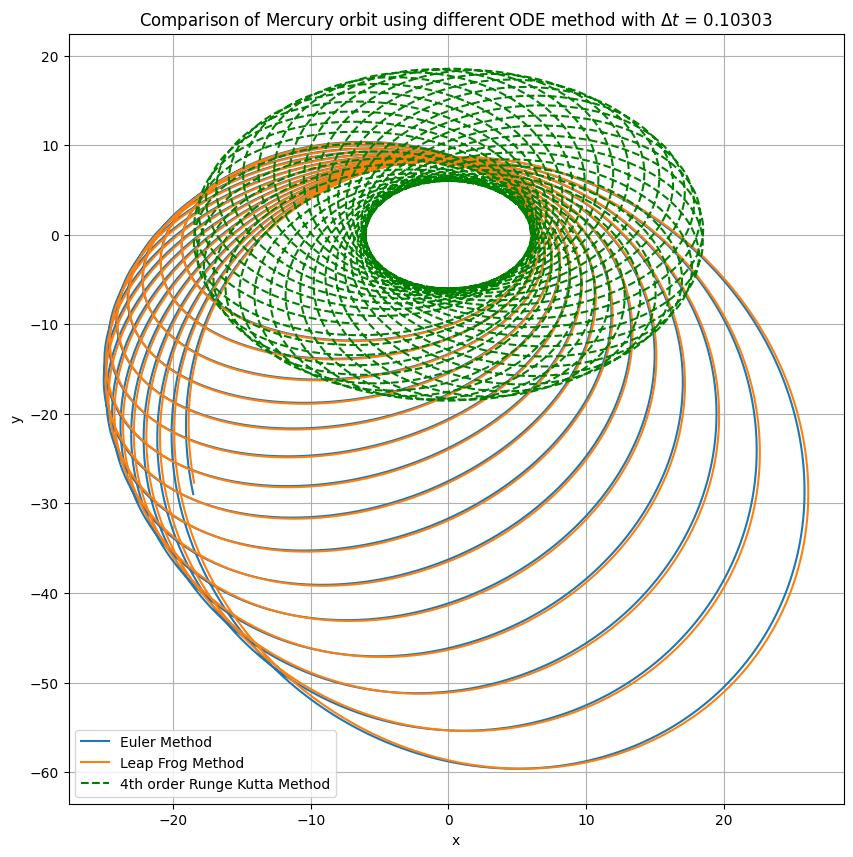

In [18]:
plt.figure(figsize=(10,10))
plt.title(rf'Comparison of Mercury orbit using different ODE method with $\Delta t$ = {np.round(dt,5)}')

plt.plot(X_Euler[ : 100000 ,0], X_Euler[  : 100000,1], label = 'Euler Method')
plt.plot(X_LF[ : 100000, 0], X_LF[ : 100000,1], label = 'Leap Frog Method')
plt.plot(X_RK[ : 100000, 0], X_RK[ : 100000,1], "g--", label = '4th order Runge Kutta Method')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()

It is clear to see from the plot that for the same step size (i.e. $\Delta t$), the 4th order Runge Kutta method perform better.

## Perihelion angular position ($\Theta$) and the shift ($\delta \Theta$)

For Mercury orbit, the perihelion position would change after every revolution. The shift, indeed for small $\alpha$ and $\beta$ ($<10^{5}$), it follows the following expression,

$$\delta \Theta (\alpha, \beta) = m_{\alpha} * \alpha + m_{\beta} * \beta$$

The General Relativity predicts $\alpha = 0$ and $\beta =3$. Therefore, in the following of this section, we would keep $\alpha=0$ and $\beta = 3$. Therefore, in the following of the section, we would

1. Fix $\alpha=0$ and vary $\beta$ value to find the $m_{\beta}$ value
2. Put $\alpha=0$ and $\beta = 3$ to the above equation and see the whether the value of $\delta \Theta$ matches with the literature value.

In [ ]:
def extract_perhelion_position(X):

    perihelion_list = []
    for i in range(1,len(X)-1):

        position_vector_before = np.array(X[i-1][:2])
        position_vector = np.array(X[i][:2])
        position_vector_after = np.array(X[i+1][:2])

        # Check if the current position is a perihelion
        if np.linalg.norm(position_vector) < np.linalg.norm(position_vector_before) and np.linalg.norm(position_vector) < np.linalg.norm(position_vector_after):
            perihelion_list.append(position_vector.tolist())

    return np.array(perihelion_list)

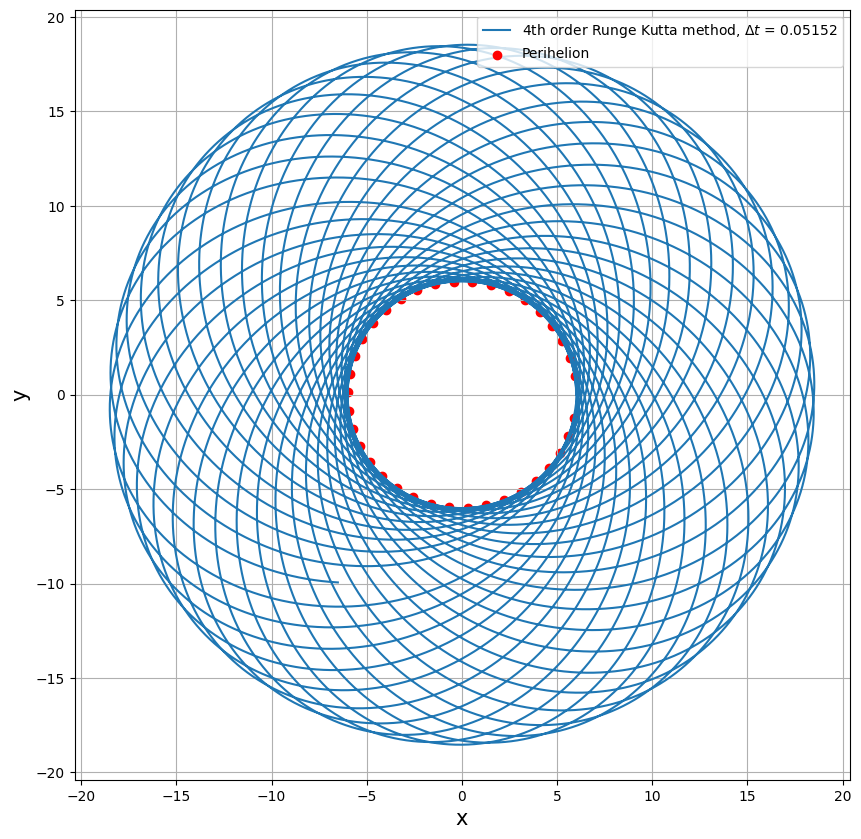

In [ ]:
perihelion_array = extract_perhelion_position(X_RK)

plt.figure(figsize=(10,10))
plt.plot(X_RK[ : , 0], X_RK[ : ,1], label = fr'4th order Runge Kutta method, $\Delta t$ = {np.round(dt,5)}')
plt.scatter(perihelion_array[:,0], perihelion_array[:,1], color = 'red', label = 'Perihelion')
plt.xlabel('x',size=15)
plt.ylabel('y',size=15)
plt.legend()
plt.grid()


In [ ]:
import copy
def extract_difference_in_perhelion(perihelion_array):

    perihelion_array_i = copy.deepcopy(perihelion_array[:-1])
    perihelion_array_i_plus_1 = copy.deepcopy(perihelion_array[1:])

    dot_product_array = np.sum(perihelion_array_i * perihelion_array_i_plus_1, axis=1)
    dot_product_array_normalized = dot_product_array / (np.linalg.norm(perihelion_array_i, axis = 1) *
                                                        np.linalg.norm(perihelion_array_i_plus_1, axis = 1))

    return dot_product_array_normalized

The delta in perihelion at beta = 0 is 0.0001771115102328502 with a standard deviation of 0.00018786102186895413
The delta in perihelion at beta = 20000 is 0.003428696477806114 with a standard deviation of 0.0002855731219082128
The delta in perihelion at beta = 40000 is 0.00663293005075118 with a standard deviation of 0.00028557312197955505
The delta in perihelion at beta = 60000 is 0.009972482707391563 with a standard deviation of 0.00024731357779528827
The delta in perihelion at beta = 80000 is 0.01344742679759766 with a standard deviation of 0.00024731357774642474
The delta in perihelion at beta = 100000 is 0.016772261693539077 with a standard deviation of 0.0002855731215333701


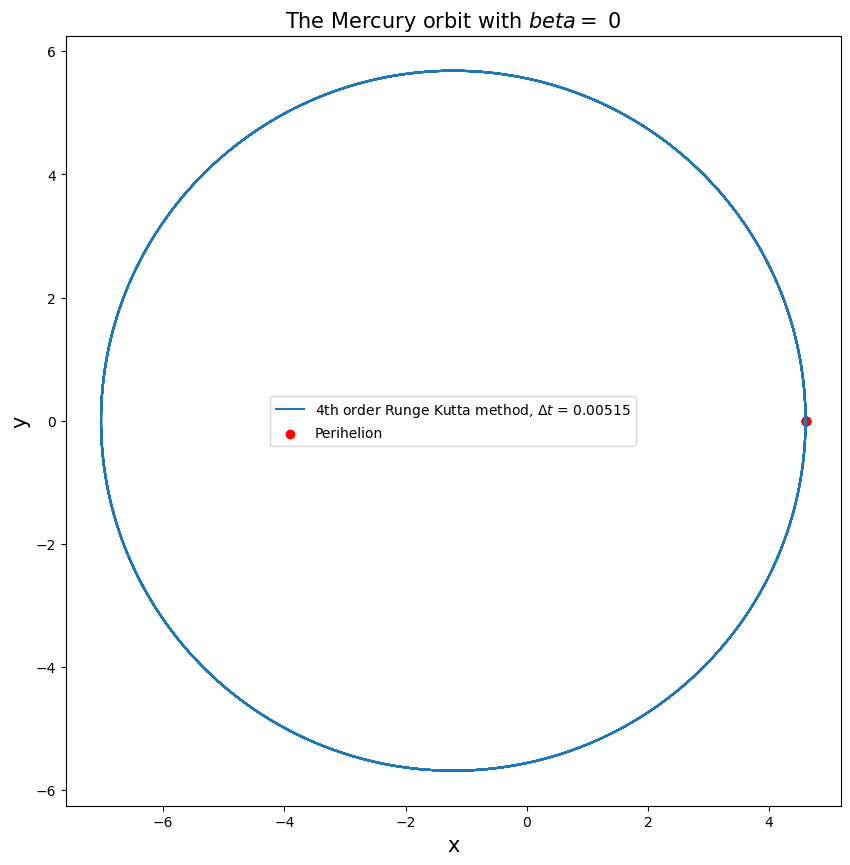

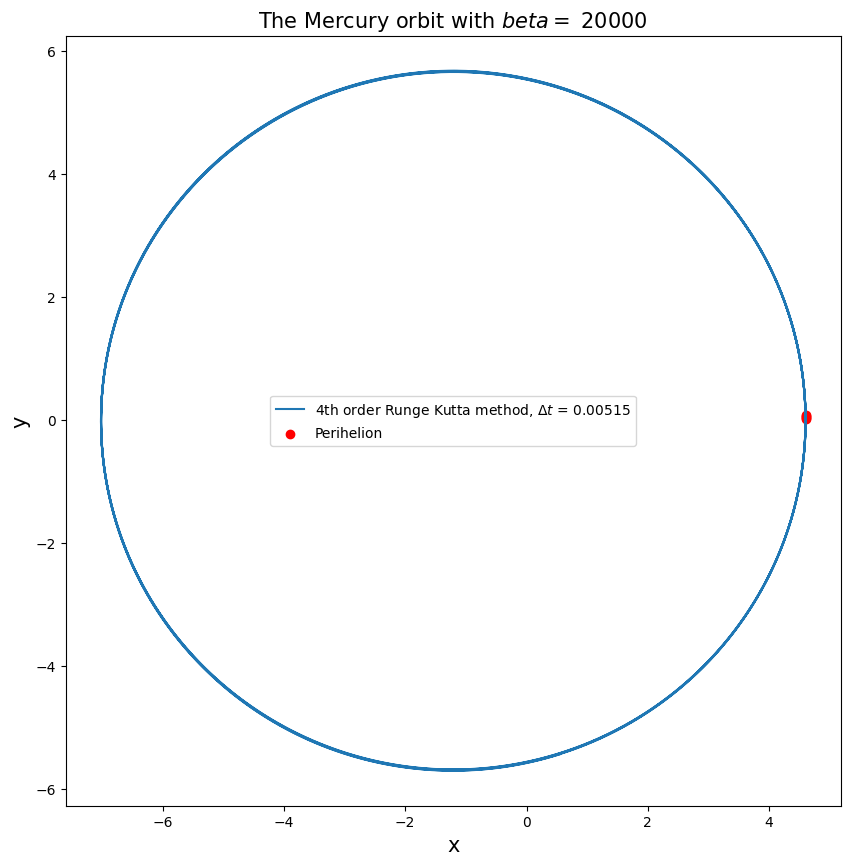

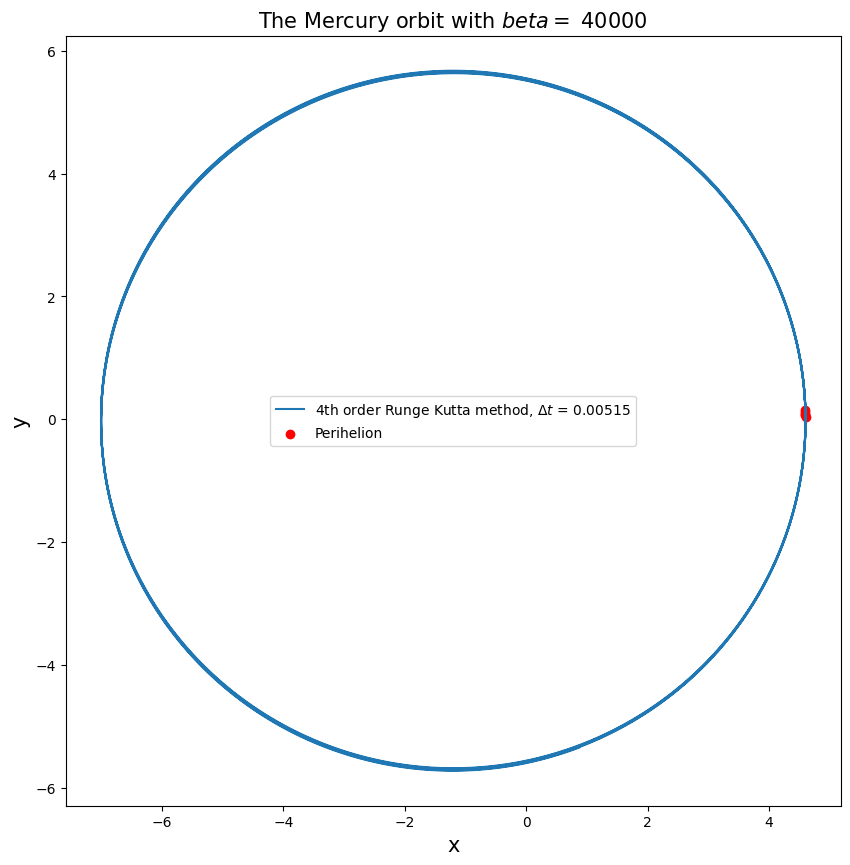

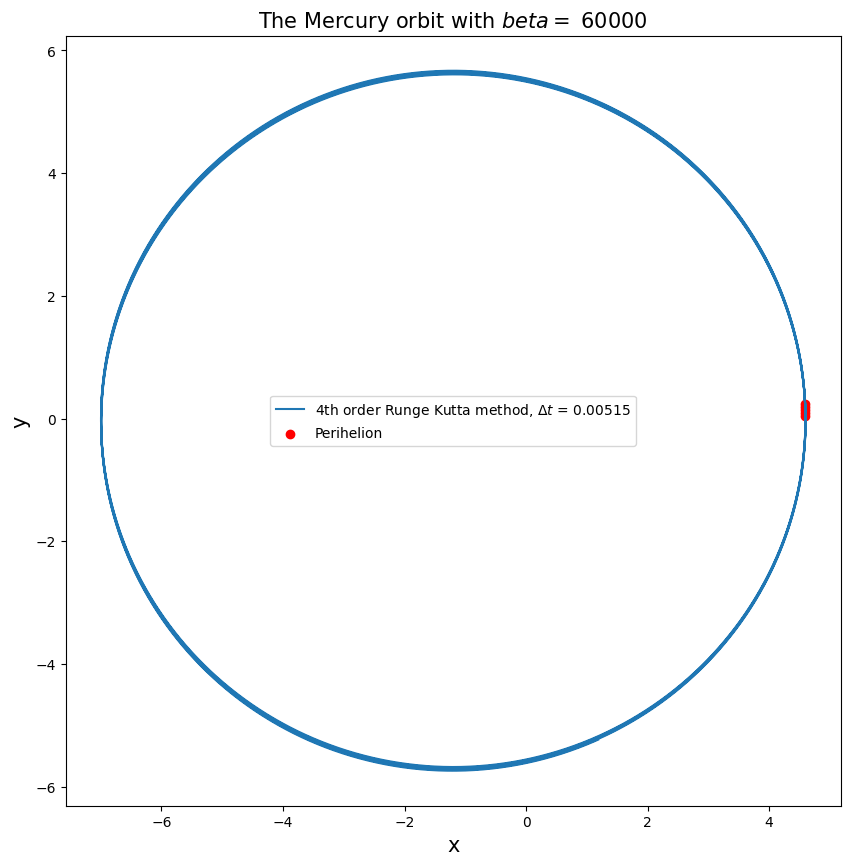

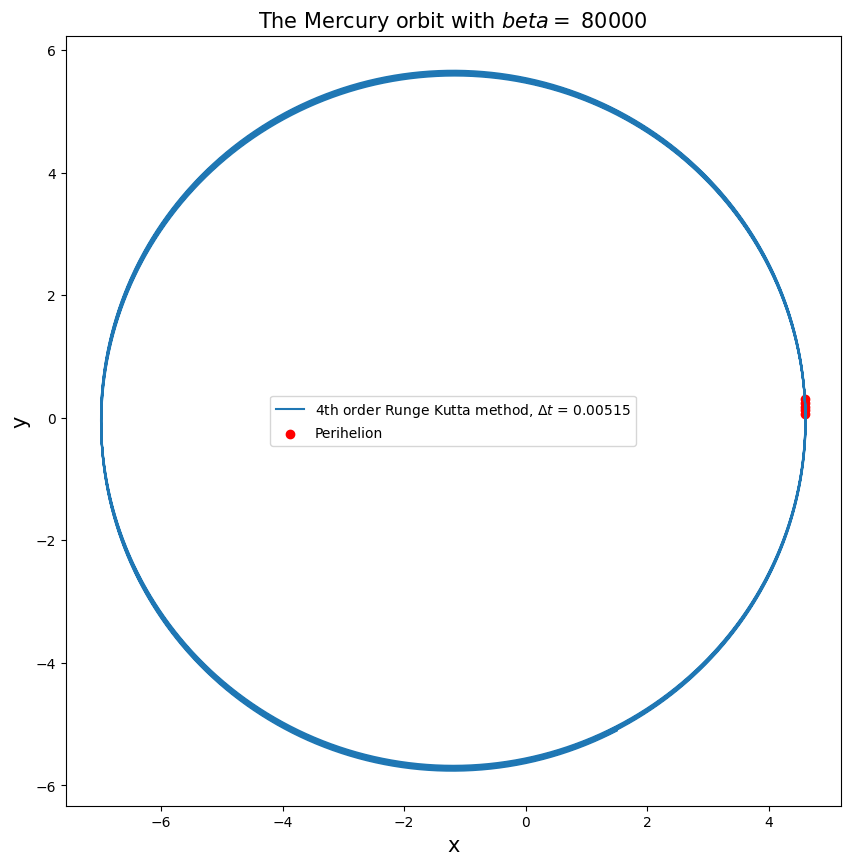

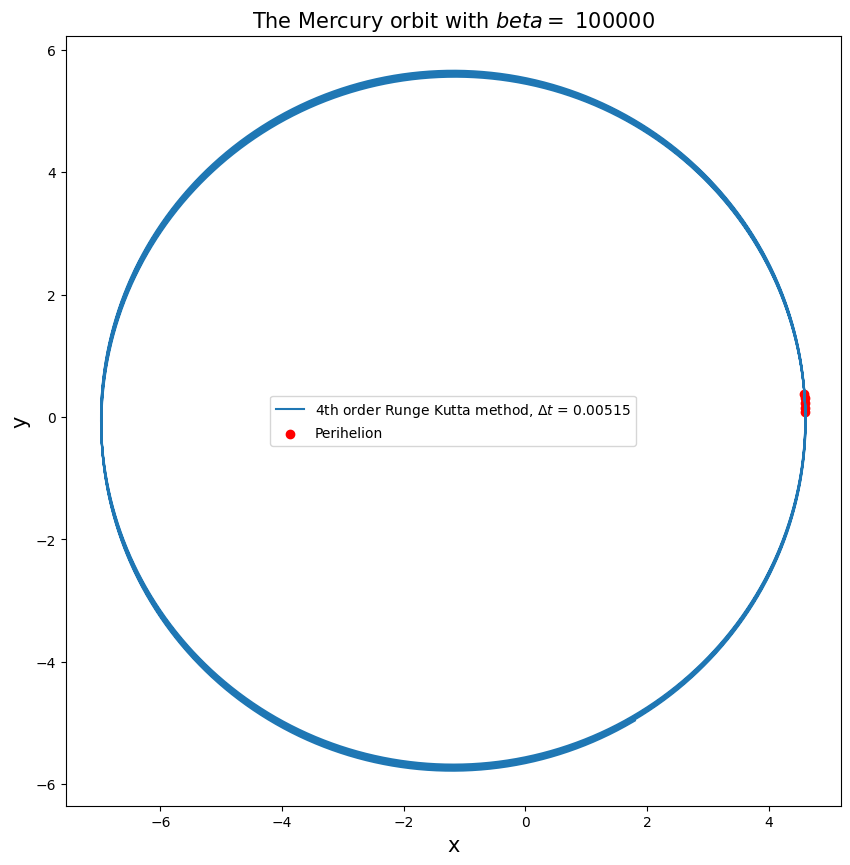

In [ ]:
rM0 = 4.6 # Initial radius of Mercury orbit, in units of R0
vM0 = 5.10e-1 # Initial orbital speed of Mercury, in units of R0/T0
c_a = 9.90e-1 # Base acceleration of Mercury, in units of R0**3/T0**2
TM = 8.80e+1 # Orbit period of Mercury
rS = 2.95e-7 # Schwarzschild radius of Sun,in units of R0
rL2 = 8.19e-7 # Specific angular momentum, in units of R0**2

# Set the suitable time step
dt =  (2 * vM0 / c_a) / 200

t = 0.0
alpha = 0
beta_list = np.arange(0,120000,20000)
nt = 100000
initial_condition = [rM0, 0.0, 0.0, vM0]

mean_list = []
sd_list = []

for beta in beta_list:
    X_RK = Runge_kutta_4th(derivative, initial_condition, dt, nt, c_a, alpha, beta, rS, rL2)
    perihelion_array = extract_perhelion_position(X_RK)
    perihelion_angular_difference = np.arccos(extract_difference_in_perhelion(perihelion_array))
    mean_list.append(np.mean(perihelion_angular_difference))
    sd_list.append(np.std(perihelion_angular_difference))

    print(f"The delta in perihelion at beta = {beta} is {mean_list[-1]} with a standard deviation of {sd_list[-1]}")

    plt.figure(figsize=(10,10))
    plt.title(fr"The Mercury orbit with $beta=$ {beta}",fontsize=15)
    plt.plot(X_RK[ : , 0], X_RK[ : ,1], label = fr'4th order Runge Kutta method, $\Delta t$ = {np.round(dt,5)}')
    plt.scatter(perihelion_array[:,0], perihelion_array[:,1], color = 'red', label = 'Perihelion')
    plt.xlabel('x',size=15)
    plt.ylabel('y',size=15)
    plt.legend()


The slope is 1.662449921893516e-07


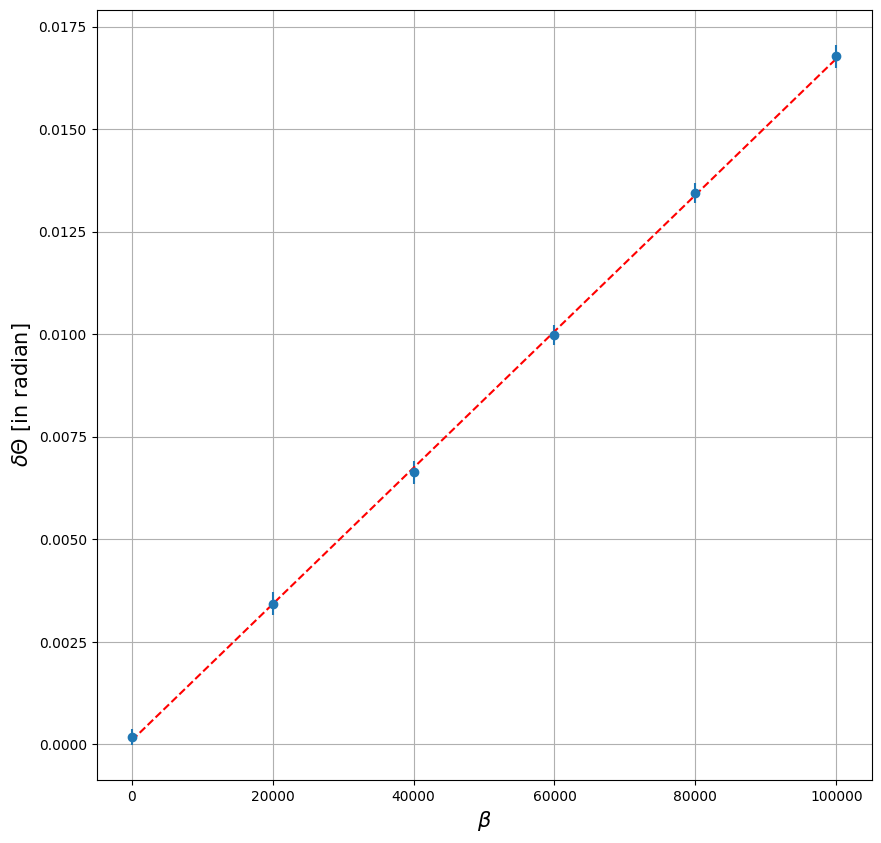

In [ ]:
plt.figure(figsize=(10,10))

# Perform linear fitting
fit = np.polyfit(beta_list, mean_list, 1)
fit_fn = np.poly1d(fit)

plt.errorbar(beta_list, mean_list, yerr=sd_list, fmt='o')
plt.plot(beta_list, fit_fn(beta_list), '--', color='red')

plt.xlabel(r'$\beta$', size=15)
plt.ylabel(r'$\delta \Theta$ [in radian]', size=15)
plt.grid()

print(f"The slope is {fit[0]}")

Put the result back to the inital equation,

$$\delta \Theta (\alpha = 0 , \beta = 3 ) = (1.66245 \times 10^{-7}) * (3) = 0.102″$$

where ″ refer to arc second and $1″ = (\frac{1}{3600})°$. Then, consider the ratio of the Earth year to Mercury $T_E/T_M \approx 4.15$, $\delta \Theta \approx 415 \times 0.102″ = 42.33″$, where our result is quite close to the theoretical prediction.